## Введение

Маркетинговые компании стремятся запускать успешные кампании, но рынок сложен, и существует несколько рабочих вариантов. Обычно для этого используют A/B-тесты — это случайный эксперимент, при котором различные версии переменной (веб-страница, элемент страницы, баннер и т. д.) одновременно показываются разным сегментам людей, чтобы определить, какая версия оказывает максимальное воздействие и влияет на показатели бизнеса.

Компании интересует ответ на два вопроса:

* Будет ли кампания успешной?

* Если кампания успешна, насколько этот успех можно причислить к рекламе?

С учетом второго вопроса, обычно проводят A/B-тест. Большинство людей будут видеть рекламу (экспериментальная группа). Малая часть людей (контрольная группа) вместо этого увидит общественное сервисное объявление (или ничего) в точно таком же размере и месте, где обычно размещается реклама.

Идея датасета заключается в анализе групп, определении успеха рекламы, расчете потенциального дохода компании от рекламы и проверке статистически значимых различий между группами.

Ссылка на датасет: https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data

## Данные и переменные

Имеются следующие колонки в csv файле:

* Index - индекс ряда
* user id - идентификатор пользователя (уникальный)
* test group - если ad, человек видел рекламу, если «psa», он видел только социальную рекламу.
* converted - если человек купил товар, то это True, иначе — False.
* total ads - количество рекламы, просмотренной человеком
* most ads day - день, когда человек увидел наибольшее количество рекламы
* most ads hour - час дня, когда человек увидел наибольшее количество рекламы

In [36]:
IS_COLAB = True
LINK = 'marketing_AB.csv'

if IS_COLAB:
    LINK = '/drive/MyDrive/Analytics/Marketing/marketing_AB.csv'

    from google.colab import drive
    drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [38]:
data = pd.read_csv(LINK)
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


Переименнуем колонки в удобный вид для работы с данными и дропнем колонку Index:

* user id -> user_id
* test group -> test_group
* total ads -> total_ads
* most ads day -> most_ads_day
* most ads hour -> most_ads_hour


In [39]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.rename(
    columns=lambda x: x.strip().replace(" ", "_"),
    inplace=True
)
data.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


## Анализ данных

In [40]:
data.shape

(588101, 6)

In [41]:
data.nunique()

user_id          588101
test_group            2
converted             2
total_ads           807
most_ads_day          7
most_ads_hour        24
dtype: int64

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [43]:
data.duplicated().any()

False

In [44]:
data.isnull().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [45]:
data.describe()

,user_id,total_ads,most_ads_hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [46]:
group_users = data.groupby('test_group', as_index=False) \
    .user_id.count()
group_users = group_users.rename(columns={'user_id': 'user_count'})
group_users

,test_group,user_count
0,ad,564577
1,psa,23524


In [47]:
group_convert_users = data.groupby(['test_group', 'converted'], as_index=False) \
    .user_id.count()
group_convert_users = group_convert_users.rename(columns={'user_id': 'user_count'})
group_convert_users

,test_group,converted,user_count
0,ad,False,550154
1,ad,True,14423
2,psa,False,23104
3,psa,True,420


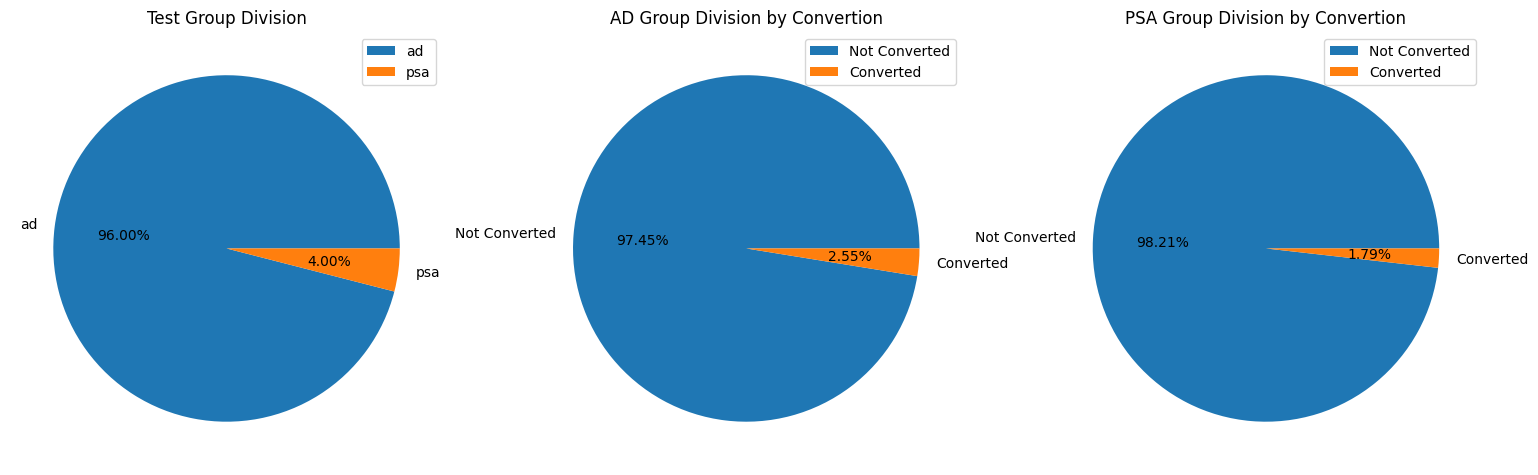

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(19,6))

labels_test = ['ad', 'psa']
labels_convert = ['Not Converted', 'Converted']

axes[0].pie(x=group_users.user_count, labels=labels_test, autopct='%.2f%%')
axes[0].set_title('Test Group Division', size=12)
axes[0].legend()

axes[1].pie(x=group_convert_users.query("test_group == 'ad'").user_count, labels=labels_convert, autopct='%.2f%%')
axes[1].set_title('AD Group Division by Convertion', size=12)
axes[1].legend()

axes[2].pie(x=group_convert_users.query("test_group == 'psa'").user_count, labels=labels_convert, autopct='%.2f%%')
axes[2].set_title('PSA Group Division by Convertion', size=12)
axes[2].legend()

plt.show()

Видно, что выборки очень сильно не сбалансированны. Имеем конверсию:

* Ad: 2.55%

* PSA: 1.79%

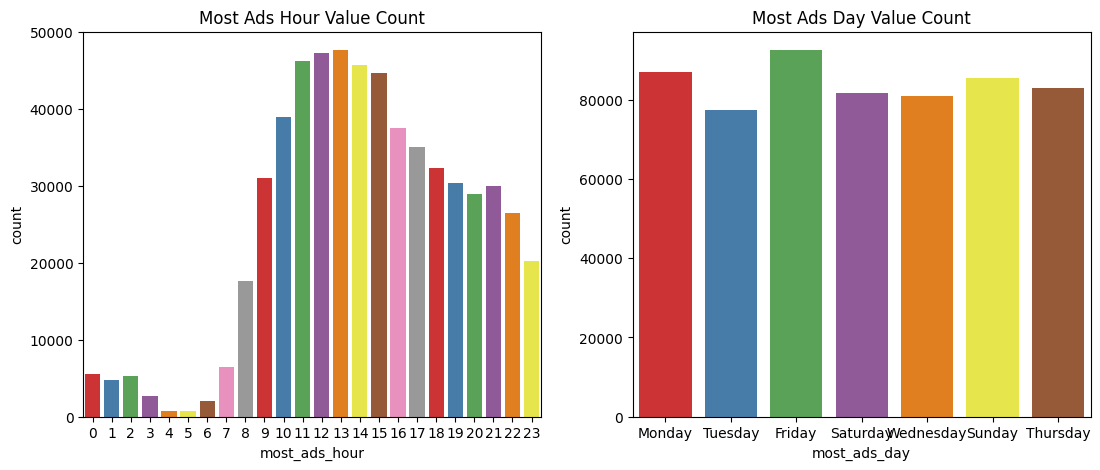

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.countplot(data=data, x='most_ads_hour', ax=axes[0], palette = "Set1")
axes[0].set_title('Most Ads Hour Value Count', size=12)

sns.countplot(data=data, x='most_ads_day', ax=axes[1], palette = "Set1")
axes[1].set_title('Most Ads Day Value Count', size=12)

plt.show()

In [50]:
def boxplot_and_distrib(df, ax1, ax2, title=""):
    sns.boxplot(x='test_group', y='total_ads', data=df, ax=ax1)
    ax1.set_xlabel("Test Group",size=12)
    ax1.set_ylabel("total_ads",size=12)
    ax1.set_title("BoxPlot" + title,size=14)

    sns.kdeplot(x='total_ads', data=df, hue='test_group', ax=ax2)
    ax2.set_xlabel("Test Group",size=12)
    ax2.set_ylabel("Density",size=12)
    ax2.set_title("Distribution" + title,size=14)

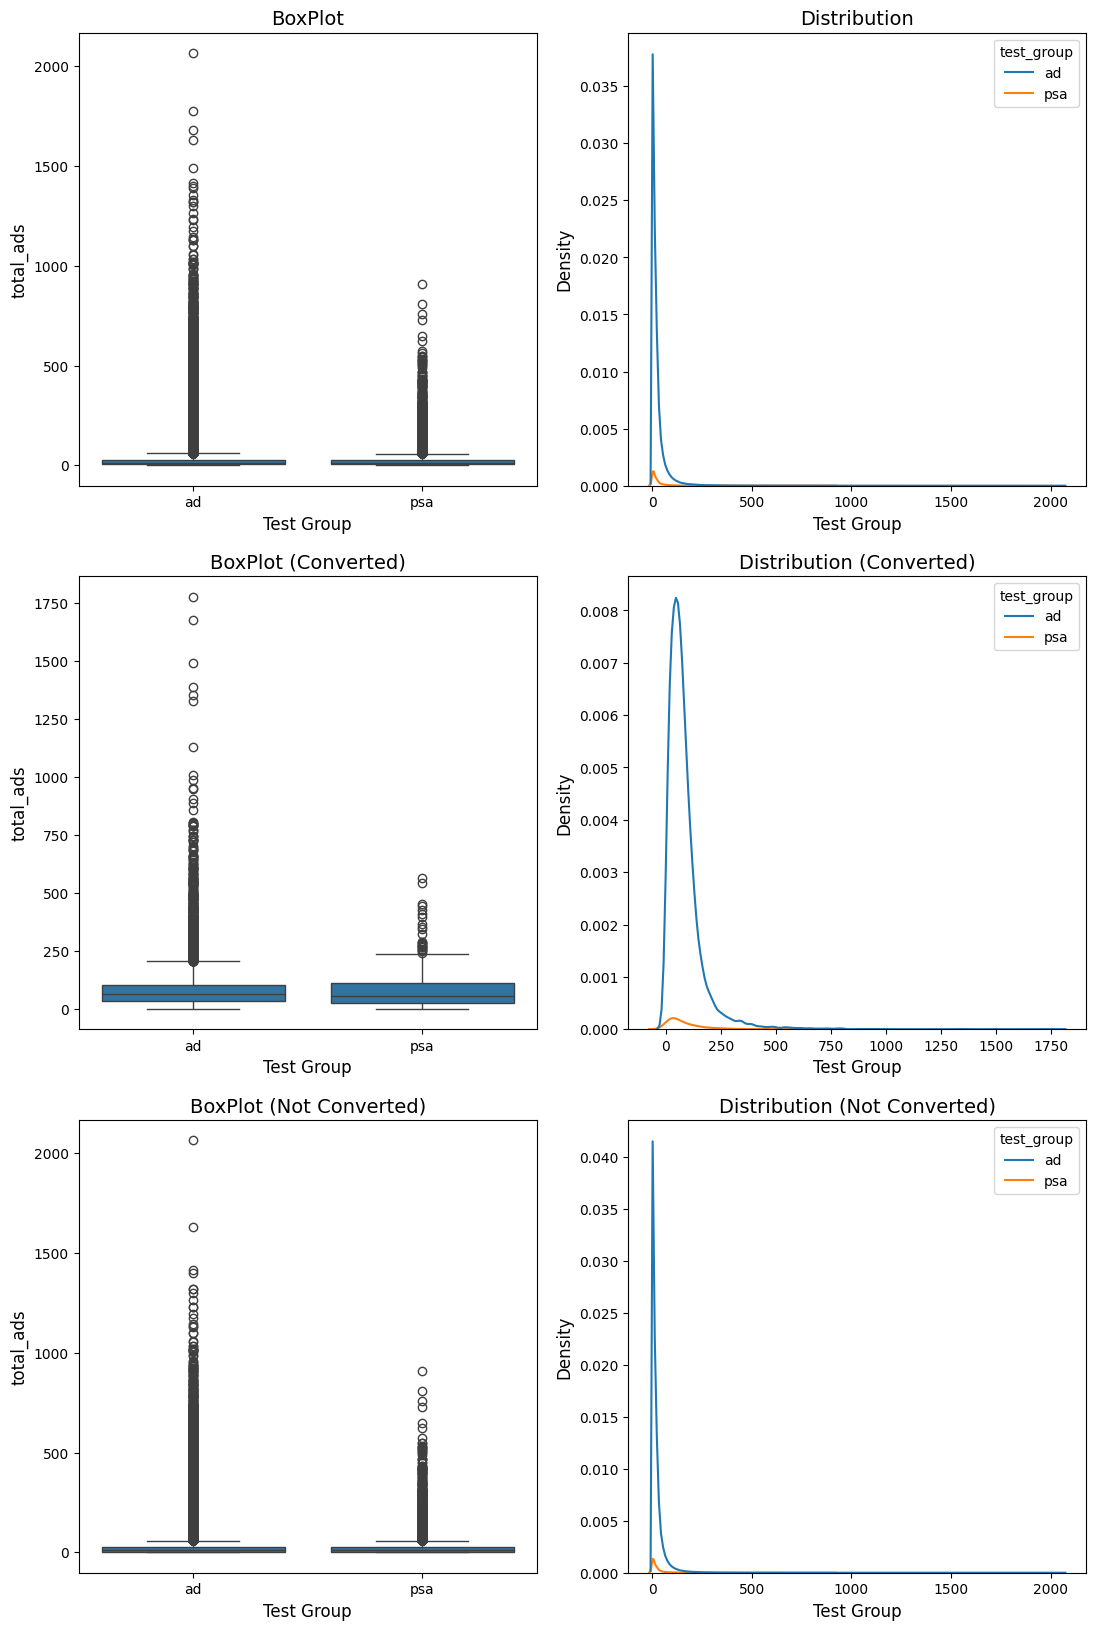

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(13, 20))

boxplot_and_distrib(data, axes[0][0], axes[0][1])
boxplot_and_distrib(data.query("converted == True"), axes[1][0], axes[1][1], ' (Converted)')
boxplot_and_distrib(data.query("converted == False"), axes[2][0], axes[2][1], ' (Not Converted)')

plt.show()

Видно, что есть выбросы (особенно в группе ad). Выкинем слишком большие значения по колонке total_ads.

In [52]:
down_limit = data['total_ads'].quantile(0.025)
up_limit = data['total_ads'].quantile(0.975)

data = data[((data['total_ads'] >= down_limit) & (data['total_ads'] <= up_limit))]

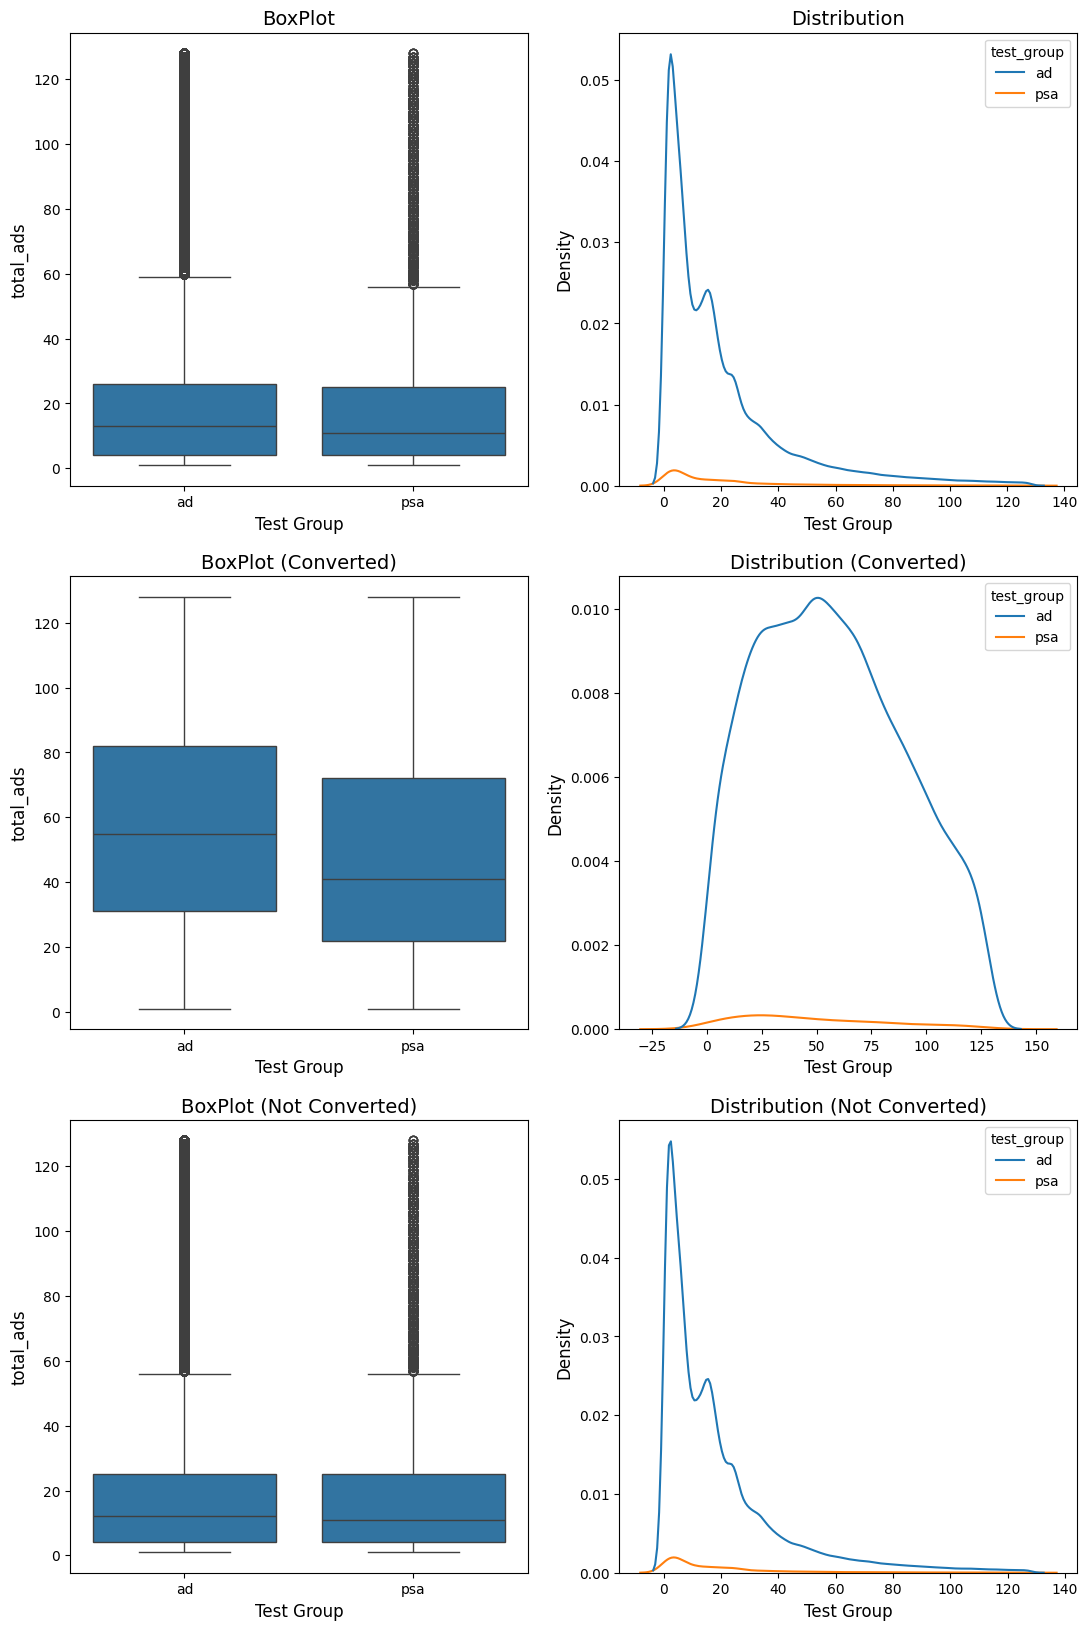

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(13, 20))

boxplot_and_distrib(data, axes[0][0], axes[0][1])
boxplot_and_distrib(data.query("converted == True"), axes[1][0], axes[1][1], ' (Converted)')
boxplot_and_distrib(data.query("converted == False"), axes[2][0], axes[2][1], ' (Not Converted)')

plt.show()

Поскольку выборки у нас сильно не сбалансированны, то посмотрим, какой минимальный объём выборки нам нужен, чтобы проводить тесты.

In [54]:
# При уровне значимости alpha = 0.05 z_score будет равен 1.96

def minimal_sample_size(population_size, error, z_score=1.96):
    p = 0.5
    sample_size = (z_score ** 2 * p * (1 - p) * population_size) / \
            (z_score ** 2 * (1 - p) + error ** 2 * (population_size - 1))
    return round(sample_size) + 1

In [55]:
minimal_sample_size(data.shape[0], 0.03)

1064

Минимальный размер выборки для уровня 0.05 меньше, чем контрольная выборка PSA. Значит, можно проводиться тесты.

Посчитаем конверсии двух групп.

In [56]:
treatment_group = data.query('test_group == "ad"')
control_group = data.query('test_group == "psa"')

In [57]:
ad_converted = treatment_group['converted']
psa_converted = control_group['converted']

In [58]:
ad_conversion = ad_converted.mean()
psa_conversion = psa_converted.mean()

print(f" Ad:\t {round(ad_conversion, 4)}\n PSA:\t {round(psa_conversion, 4)}")

 Ad:	 0.022
 PSA:	 0.0145


Видно, что значения для группы PSA меньше, чем для группы Ad.

## A/B-тестирование для Convertion Rate

Гипотезы для проверки:

* $H_0: \mu_{ad} = \mu_{psa}$

* $H_1: \mu_{ad} \neq \mu_{psa}$

где $\mu_{ad}, \mu_{psa}$ - средние значения в выборках

### Bootstrap

In [59]:
boot_ad = []
boot_psa = []
NUM_SAMPLES = 1000

for i in range(NUM_SAMPLES):
    boot_ad_mean = ad_converted.sample(frac=1, replace=True).mean()
    boot_psa_mean = psa_converted.sample(frac=1, replace=True).mean()
    boot_ad.append(boot_ad_mean)
    boot_psa.append(boot_psa_mean)

boot_ad = pd.DataFrame(boot_ad)
boot_psa = pd.DataFrame(boot_psa)

boot_ad.columns = ['ad_converted']
boot_psa.columns = ['psa_converted']

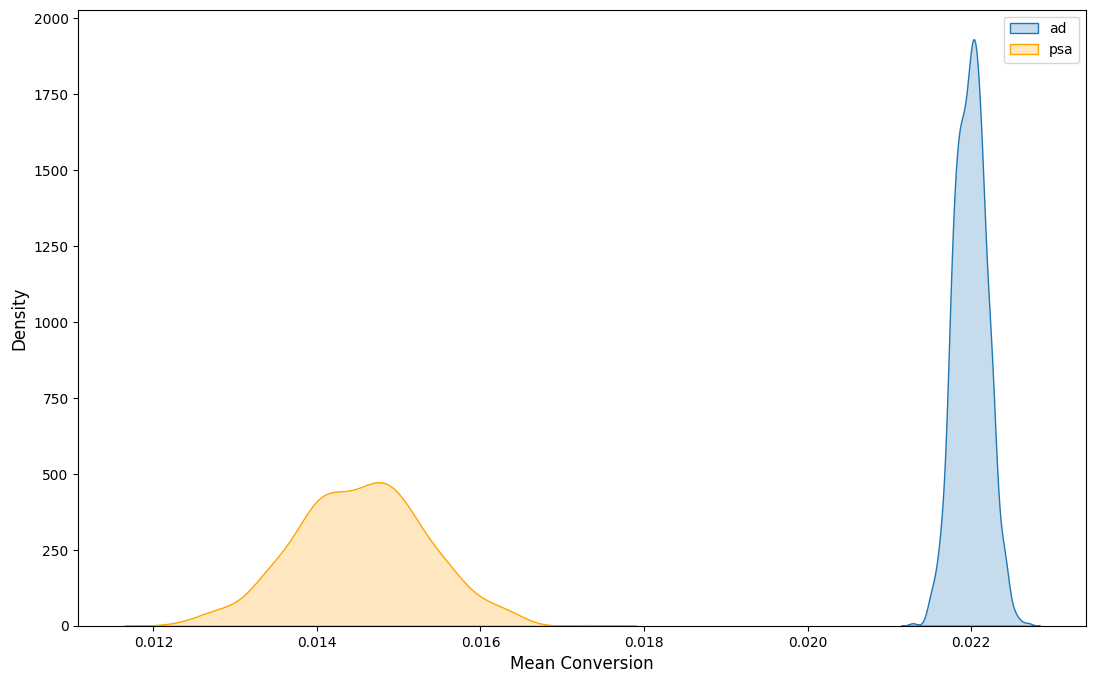

In [60]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,8))

sns.kdeplot(boot_ad.squeeze(), shade=True, label='ad', ax=ax1)
sns.kdeplot(boot_psa.squeeze(), shade=True, label='psa', ax=ax1, color='orange')

ax1.set_xlabel("Mean Conversion",size=12)
ax1.set_ylabel("Density",size=12)
ax1.legend()

plt.show()

In [61]:
boot_strap = pd.concat([boot_ad, boot_psa], axis=1)
boot_strap['difference'] = (boot_strap['ad_converted'] - boot_strap['psa_converted']) \
    / boot_strap['psa_converted']

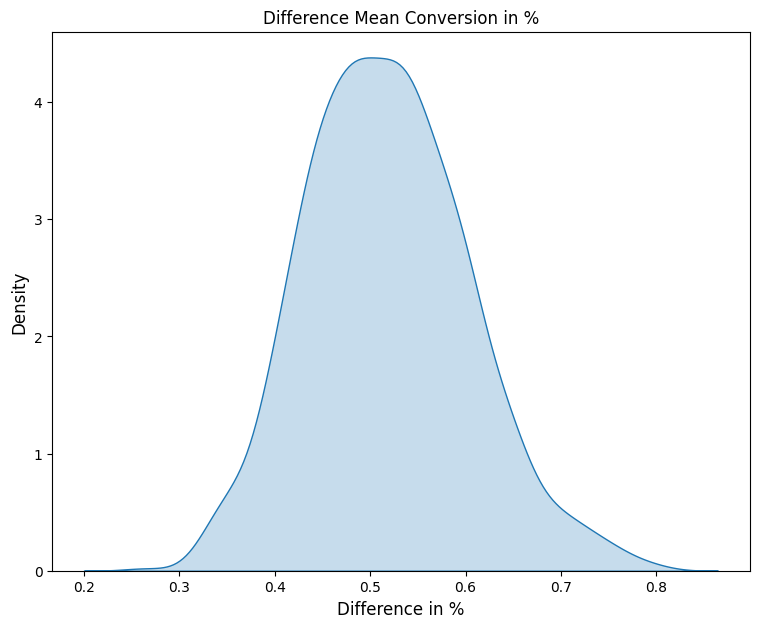

In [62]:
fig, ax1 = plt.subplots(1, 1, figsize=(9,7))

sns.kdeplot(boot_strap['difference'].squeeze(), shade=True, label='psa', ax=ax1)
ax1.set_xlabel("Difference in %", size=12)
ax1.set_ylabel("Density",size=12)
ax1.set_title('Difference Mean Conversion in %', size = 12)

plt.show()

In [63]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [64]:
prob_boot = (boot_strap['difference'] > 0).sum() / len(boot_strap['difference'])

print("{:.1f}%".format(prob_boot * 100))

100.0%


In [65]:
paid_left, paid_right = stat_intervals(boot_strap['difference'])

print("[{:.3f}, {:.3f}]".format(paid_left, paid_right))

[0.358, 0.701]


Видно, что на уровне 0.05 доверительный интервал не содержит 0 и все разности элементов в бутстрап-выборках больше 0. А, значит, статистически значимый результат есть и можно отклонить $H_0$.

### T-тест

In [66]:
stat, pvalue = stats.ttest_ind(ad_converted, psa_converted)

print("Stat: {:.4f} Pvalue: {:.4f}".format(stat, pvalue))

Stat: 7.6166 Pvalue: 0.0000


Аналогичный результат.

### Хи-квадрат

In [67]:
converted_tabel = pd.crosstab(data['test_group'], data['converted'], margins=False)
converted_tabel

converted,False,True
test_group,,
ad,538556,12116
psa,22543,332


In [68]:
stat, pvalue, dof, expected_table = stats.chi2_contingency(converted_tabel)

print("Stat: {:.4f} Pvalue: {:.4f}".format(stat, pvalue))
print('Expected Table:')
print(expected_table)

Stat: 57.6547 Pvalue: 0.0000
Expected Table:
[[5.38720468e+05 1.19515315e+04]
 [2.23785315e+04 4.96468467e+02]]


Аналогичный результат.

## Выводы

Получено, что:

* Среднее значение коверсии группы PSA (1.79%, после удаления выбросов - 1.45%) меньше, чем среднее значение группы Ad (2.55%, после удаления выбросов - 2.2%).

* Т-тест, критерий Хи-квадрат и Bootstrap метод на уровне значимости 0.05 есть статистически значимые различия.

Таким образом, конверсия будет выше при использовании рекламы, а не только социальных объявлений.